In [ ]:
# !pip install wget
# !git clone https://github.com/bearpaw/clothing-co-parsing.git

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import zipfile
import sys

In [ ]:
!mkdir 

In [5]:
sys.path.insert(0, '/content/parcial2/data')
sys.path.insert(1, '/content/parcial2')

In [6]:
!ls
%cd parcial2/

gdrive	parcial2  sample_data
/content/parcial2


In [8]:
with zipfile.ZipFile('/content/gdrive/MyDrive/Sis421MAAL/Parciales/Parcial2/datasets/Cloth.zip', 'r') as zip_ref:
    zip_ref.extractall('./cloth')

In [9]:
DATA_DIR = '/content/parcial2/cloth'

dataset = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
dataset = dataset[['image_path', 'label_type', 'label_path']]
dataset['image_path'] = dataset['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
dataset['label_path'] = dataset['label_path'].apply(lambda lbl_pth: os.path.join(DATA_DIR, 'labels', lbl_pth))

dataset = dataset[dataset['label_type']=='pixel-level']

dataset = dataset.sample(frac=1).reset_index(drop=True)

valid_df = dataset.sample(frac=0.05, random_state=42)
train_df = dataset.drop(valid_df.index)
len(train_df), len(valid_df)

(954, 50)

In [10]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Obtener nombre de clases
class_names = class_dict['class_name'].tolist()
# Reescritura de la clase 'nula' para evitar un valor NaN
class_names[0] = 'null'
# Obtener el rgb de las clases
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('Todas las clases de conjuntos de datos y sus valores RGB correspondientes en las etiquetas:')
print('\nNombre de las clases: ', class_names)
#print('\nValor de RGB de las clases: ', class_rgb_values)

Todas las clases de conjuntos de datos y sus valores RGB correspondientes en las etiquetas:

Nombre de las clases:  ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit', 'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress', 'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie', 'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace', 'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf', 'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings', 'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie', 'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']


In [11]:
select_classes = ['null', 'accessories', 'bag', 'belt', 'blazer', 'blouse', 'bodysuit',
                  'boots', 'bra', 'bracelet', 'cape', 'cardigan', 'clogs', 'coat', 'dress',
                  'earrings', 'flats', 'glasses', 'gloves', 'hair', 'hat', 'heels', 'hoodie',
                  'intimate', 'jacket', 'jeans', 'jumper', 'leggings', 'loafers', 'necklace',
                  'panties', 'pants', 'pumps', 'purse', 'ring', 'romper', 'sandals', 'scarf',
                  'shirt', 'shoes', 'shorts', 'skin', 'skirt', 'sneakers', 'socks', 'stockings',
                  'suit', 'sunglasses', 'sweater', 'sweatshirt', 'swimwear', 't-shirt', 'tie',
                  'tights', 'top', 'vest', 'wallet', 'watch', 'wedges']

# Obtenga valores RGB de las clases requeridas
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

In [12]:
# función auxiliar para la visualización de datos
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Realice una codificación en caliente en la etiqueta
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Realice una codificación en caliente inversa en labels / preds
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

# Realice la codificación de colores en las salidas inversas uno-caliente
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [13]:
class ClothesDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['label_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # leer image y masks
        image = cv2.imread(self.image_paths[i])[:,:,::-1]
        mask = cv2.imread(self.mask_paths[i])[:,:,::-1]
        
        # una máscara de codificación en caliente
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # aplicar aumento
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # aplicar procesamiento
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

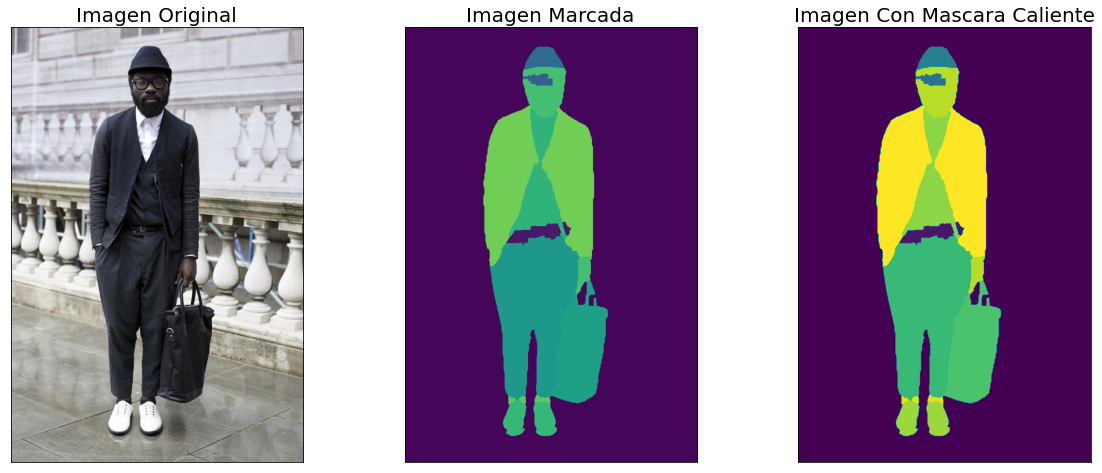

In [14]:
dataset = ClothesDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    Imagen_Original = image,
    imagen_marcada = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    imagen_con_mascara_caliente = reverse_one_hot(mask)
)

In [ ]:
!ls

1aa.npy  clothing-co-parsing  drive  gdrive  parcial2  sample_data


In [15]:
%cd ..

/content


In [16]:
from pathlib import Path
path = Path('./parcial2/cloth')
imgs = [path/'images'/i for i in os.listdir(path/'images')]
#ixs = [i.split('_')[-1] for i in os.listdir(path/'MRIs')]
#masks = [path/'labels/pixel_level_labels_colored'/f'segm_{ix}' for ix in ixs]
masks = [path/'labels/pixel_level_labels_colored'/i for i in os.listdir(path/'labels/pixel_level_labels_colored')]

len(imgs), len(masks)

(2098, 1004)

OSError: ignored

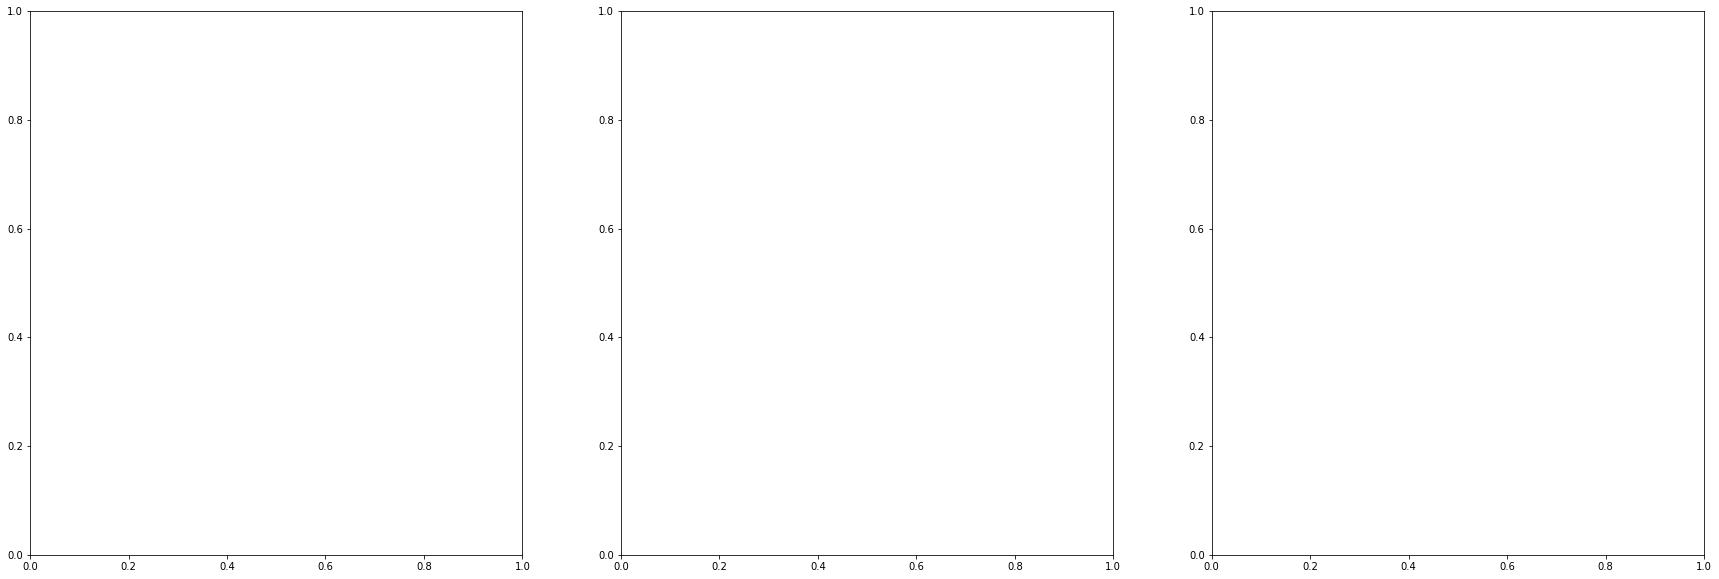

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pl
from scipy import misc

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

# with open(imgs[0], 'rb') as handle:
#     my_array = pl.load(handle)
# img = np.array(my_array)

img = np.load(imgs[0], allow_pickle=True)
mask = np.load(masks[0], allow_pickle=True)
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.4)
plt.show()

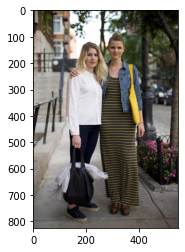

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as img

image = img.imread('/content/parcial2/cloth/images/1386.jpg')
plt.imshow(image)
plt.show()

In [19]:
from PIL import Image
from numpy import asarray

In [ ]:
#imgs = [path/'images'/i for i in os.listdir(path/'images')]
l = []
for i in imgs:
    image = Image.open(i)
    numpydata = np.array(image)
    l.append(numpydata)
#image = Image.open('/content/clothing-co-parsing/photos/2098.jpg')
#numpydata = asarray(image)

#  shape
print(l)
#print(numpydata)

#np.save('1aa.npy',numpydata)

In [ ]:
type(l)

numpy.ndarray

In [ ]:
l=np.asarray(l)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
l = torch.from_numpy(l)
l.shape

TypeError: ignored